In [ ]:
#モジュールインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
#使用デバイス判別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cuda


In [ ]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [ ]:
#データ読み込み
ipad_data = pd.read_csv("drive/MyDrive/lab/device_dataset/ipad_T.csv")
iphone_data = pd.read_csv("drive/MyDrive/lab/device_dataset/iPhone_T.csv")
kirin_data = pd.read_csv("drive/MyDrive/lab/device_dataset/Kirin_T.csv")
rakko_data = pd.read_csv("drive/MyDrive/lab/device_dataset/rakko_T.csv")


ipad_data = ipad_data.head(50000)
iphone_data = iphone_data.head(50000)
kirin_data = kirin_data.head(50000)
rakko_data = rakko_data.head(50000)


"""
ipad_data[["link"]] = 0
iphone_data[["link"]] = 0
kirin_data[["link"]] = 0
rakko_data[["link"]] = 0
"""

datas = {1:ipad_data, 2:iphone_data, 3:kirin_data, 4:rakko_data}
ips = ["192.168.100.8","192.168.100.14","192.168.100.10","192.168.100.12"]

for n,df in datas.items():

  for index, data in df.iterrows():
    if data["Source"] == ips[n-1]:
      df.loc[index, "link"] = 0
    else:
      df.loc[index, "link"] = 1

  print(index)


  df['rate'] = df['Length'] / (df['interval'] + 0.0000000000001)
  #df['no_cum'] = df["cumbyte"] / n
  #df = df[["Length","interval","rate","link","no_cum"]]

  #drop_index = df.index[df["Source"] == ips[n-1]]
  #drop_index = df.index[df["Destination"] == ips[n-1]]
  #datas[n] = df.drop(drop_index)

num_feture=3

27104
25510
26159
26877


In [ ]:
rakko_data.shape

(26878, 9)

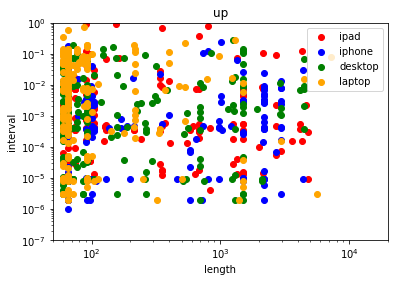

In [ ]:
n = 200

X1 = datas[1]["Length"].sample(n)
Y1 = datas[1]["interval"].sample(n)

X2 = datas[2]["Length"].sample(n)
Y2 = datas[2]["interval"].sample(n)

X3 = datas[3]["Length"].sample(n)
Y3 = datas[3]["interval"].sample(n)

X4 = datas[4]["Length"].sample(n)
Y4 = datas[4]["interval"].sample(n)


ax = plt.gca()

plt.scatter(x=X1, y=Y1, c="red",label="ipad")
plt.scatter(x=X2, y=Y2, c="blue",label="iphone")
plt.scatter(x=X3, y=Y3, c="green",label="desktop")
plt.scatter(x=X4, y=Y4, c="orange",label="laptop")

plt.xlabel("length")
plt.ylabel("interval")
plt.title("up")
plt.legend()

plt.xlim(50,20000)
plt.ylim(10**-7,1)

ax.set_yscale('log')  # y軸をlogスケールで描く
ax.set_xscale('log')  # x軸をlogスケールで描く

In [ ]:
##データ正規化
#モジュールインポート
from sklearn.preprocessing import MinMaxScaler

labels = np.empty(0)
trains = np.empty(0)
data_num = 0
sequence = 10

for index in datas:
  data = datas[index]
  data = data[["Length","interval","rate"]].to_numpy()
  #data = data[["Length","interval","rate","no_cum"]].to_numpy()

  #データ正規化インスタンス生成
  std = MinMaxScaler()
  X = data
  X = std.fit_transform(X)
  data= X

  label_index = index
  num = len(datas[index])/sequence
  num = int(np.floor(num))
  data_num += num
  print("データ{}の要素数は{}です".format(label_index,num))

  label = np.full(num,label_index-1)
  labels = np.append(labels, label)
  trains = np.append(trains,data)

trains = np.resize(trains, (data_num,sequence,num_feture))
#trains = np.resize(trains, (data_num,1,sequence,num_feture))#CNNを使う際はこっち
target =labels
data_ = trains

データ1の要素数は2710です
データ2の要素数は2551です
データ3の要素数は2616です
データ4の要素数は2687です


In [ ]:
trains.shape

(2496, 1, 10, 3)

In [ ]:
from sklearn.model_selection import train_test_split
#データセットをトレーニングデータと検証データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(data_, target, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

# Tensor型に変換
# 学習に入れるときはfloat型になっている必要があるのここで変換してしまう
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# 2. Datasetの作成
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

# 3. DataLoaderの作成
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": valid_dataloader, "test": test_dataloader}

In [ ]:
print(data_.shape)

(5146, 1, 10, 3)


In [ ]:
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す
print("imges size = ", imges.size())
print("labels size = ", labels.size())

imges size =  torch.Size([64, 10, 3])
labels size =  torch.Size([64])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)
        #conv2d(input_cunnel,output_cunnel,karnel,padding)
        self.conv1 = nn.Conv2d(1,16,2,padding=1)
        self.conv2 = nn.Conv2d(16,32,2,padding=1)

        self.fc1 = nn.Linear(384, 120)
        self.fc2 = nn.Linear(120, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        #x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class RNN(nn.Module):

    def __init__(self):
        super(RNN, self).__init__()
        self.seq_len = sequence            # 時系列のSequenceとしてLSTMに入力する
        self.feature_size = num_feture         # 特徴量の次元としてLSTMに入力する
        self.hidden_layer_size = 3   # 隠れ層のサイズ
        self.layers = 2          # LSTMのレイヤー数(LSTMを何層重ねるか)
        self.rnn = nn.RNN(self.feature_size,
                            self.hidden_layer_size,
                            num_layers = self.layers)

        self.fc = nn.Linear(self.hidden_layer_size, 4)

    def init_hidden(self, batch_size): # LSTMの隠れ層 hidden を初期化
        hedden = torch.zeros(self.layers, batch_size, self.hidden_layer_size)
        return hedden

    def forward(self, x):
        batch_size = x.shape[0]
        self.hidden = self.init_hidden(batch_size)

        x = x.view(batch_size, self.seq_len, self.feature_size)  # (Batch, Cannel, Height, Width) -> (Batch, Height, Width) = (Batch, Seqence, Feature)
                                                                 # 画像の Height を時系列のSequenceに、Width を特徴量の次元としてLSTMに入力する
        x = x.permute(1, 0, 2)                                   # (Batch, Seqence, Feature) -> (Seqence , Batch, Feature)

        rnn_out, h_n = self.rnn(x, self.hidden)    # LSTMの入力データのShapeは(Seqence, Batch, Feature)
                                                                 # (h_n) のShapeは (num_layers, batch, hidden_size)
        x = h_n[-1,:,:]                                          # lstm_layersの最後のレイヤーを取り出す  (B, h)
        x = self.fc(x)

        return x

In [ ]:
class LSTM(nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()
        self.seq_len = sequence            # 画像の Height を時系列のSequenceとしてLSTMに入力する
        self.feature_size = num_feture         # 画像の Width を特徴量の次元としてLSTMに入力する
        self.hidden_layer_size = 32   # 隠れ層のサイズ
        self.lstm_layers = 2          # LSTMのレイヤー数(LSTMを何層重ねるか)
        self.lstm = nn.LSTM(self.feature_size,
                            self.hidden_layer_size,
                            num_layers = self.lstm_layers)

        self.fc = nn.Linear(self.hidden_layer_size, 4)

    def init_hidden_cell(self, batch_size): # LSTMの隠れ層 hidden と記憶セル cell を初期化
        hedden = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size)
        cell = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size)
        return (hedden, cell)

    def forward(self, x):
        batch_size = x.shape[0]
        self.hidden_cell = self.init_hidden_cell(batch_size)

        x = x.view(batch_size, self.seq_len, self.feature_size)  # (Batch, Cannel, Height, Width) -> (Batch, Height, Width) = (Batch, Seqence, Feature)
                                                                 # 画像の Height を時系列のSequenceに、Width を特徴量の次元としてLSTMに入力する
        x = x.permute(1, 0, 2)                                   # (Batch, Seqence, Feature) -> (Seqence , Batch, Feature)

        lstm_out, (h_n, c_n) = self.lstm(x, self.hidden_cell)    # LSTMの入力データのShapeは(Seqence, Batch, Feature)
                                                                 # (h_n) のShapeは (num_layers, batch, hidden_size)
        x = h_n[-1,:,:]                                          # lstm_layersの最後のレイヤーを取り出す  (B, h)
        x = self.fc(x)

        return x

In [ ]:
class GRU(nn.Module):

    def __init__(self):
        super(GRU, self).__init__()
        self.seq_len = sequence            # 時系列のSequenceとしてGRUに入力する
        self.feature_size = num_feture         # Width を特徴量の次元としてGRUに入力する
        self.hidden_layer_size = 32   # 隠れ層のサイズ
        self.gru_layers = 2          # GRUのレイヤー数(GRUを何層重ねるか)
        self.gru = nn.GRU(self.feature_size,
                            self.hidden_layer_size,
                            num_layers = self.gru_layers)

        self.fc = nn.Linear(self.hidden_layer_size, 4)

    def init_hidden(self, batch_size): # LSTMの隠れ層 hidden と記憶セル cell を初期化
        hedden = torch.zeros(self.gru_layers, batch_size, self.hidden_layer_size)
        return hedden

    def forward(self, x):
        batch_size = x.shape[0]
        self.hidden = self.init_hidden(batch_size)

        x = x.view(batch_size, self.seq_len, self.feature_size)  # (Batch, Cannel, Height, Width) -> (Batch, Height, Width) = (Batch, Seqence, Feature)
                                                                 # 画像の Height を時系列のSequenceに、Width を特徴量の次元としてLSTMに入力する
        x = x.permute(1, 0, 2)                                   # (Batch, Seqence, Feature) -> (Seqence , Batch, Feature)

        gru_out, h_n= self.gru(x, self.hidden)    # LSTMの入力データのShapeは(Seqence, Batch, Feature)
                                                                 # (h_n) のShapeは (num_layers, batch, hidden_size)
        x = h_n[-1,:,:]                                          # lstm_layersの最後のレイヤーを取り出す  (B, h)
        x = self.fc(x)

        return x

In [ ]:
net = LSTM()
print(net)

LSTM(
  (lstm): LSTM(3, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
#損失関数の定義
criterion = nn.CrossEntropyLoss()

#最適化手法の定義
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.RMSprop(net0.parameters(), lr=0.001)

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs):

  train_loss_history = np.empty(0)
  train_acc_history = np.empty(0)
  val_loss_history = np.empty(0)
  val_acc_history = np.empty(0)
  preds_history = np.empty(0)

  for epoch in range(num_epochs):
      print("\n")
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-------------')

  #epochごとの学習と検証のループ
      for phase in ['train', 'val']:
          if phase == 'train':   # モデルを訓練モードに設定
              net.train()
          else:                  # モデルを推論モードに設定
              net.eval()

          epoch_loss = 0.0       # エポックの損失和
          epoch_corrects = 0     # エポックの正解数

          # DataLoaderからデータをバッチごとに取り出す
          for inputs, labels in dataloaders_dict[phase]:

              optimizer.zero_grad()  # optimizerの初期化

              # 順伝播計算
              # 学習時のみ勾配を計算させる設定にする
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = net(inputs)                 # 順伝播
                  loss = criterion(outputs, labels)     # 損失を計算
                  _, preds = torch.max(outputs, 1)      # ラベルを予測

                  # 訓練時はバックプロパゲーション
                  if phase == 'train':
                      loss.backward()                   # 逆伝搬の計算
                      optimizer.step()                  # パラメータの更新

                  # イテレーション結果の計算
                  # lossの合計を更新
                  epoch_loss += loss.item() * inputs.size(0)
                  # 正解数の合計を更新
                  epoch_corrects += torch.sum(preds == labels.data)
                  preds_history = np.append(preds_history, preds)

          # epochごとのlossと正解率を表示
          epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
          epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

          if phase == 'train':
            train_loss_history = np.append(train_loss_history, epoch_loss)
            train_acc_history = np.append(train_acc_history, epoch_acc)

          if phase == 'val':
            val_loss_history = np.append(val_loss_history, epoch_loss)
            val_acc_history = np.append(val_acc_history, epoch_acc)


          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

  fig = plt.figure()
  axis1 = fig.subplots()
  #axis2 = axis1.twinx()
  x = np.arange(num_epochs)

  line1 = axis1.plot(x, train_acc_history, color='C0',label='train_acc')
  line2 = axis1.plot(x, val_acc_history, color='C1', label='val_acc')

  h1, l1 = axis1.get_legend_handles_labels()
  #h2, l2 = axis2.get_legend_handles_labels()
  axis1.legend(h1, l1, loc='lower right')
  #axis1.legend(h1+h2, l1+l2, loc='lower right')

  axis1.set_xlabel("epochs")
  axis1.set_ylabel("accuracy")
  axis1.grid(False)
  #axis2.set_ylabel("accuracy")
  plt.show()
  print(train_acc_history)

In [ ]:
import time

# 処理前の時刻
t1 = time.time()

num_epochs = 100
train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs)

# 処理後の時刻
t2 = time.time()

# 経過時間を表示
elapsed_time = t2-t1
print(f"学習時間：{elapsed_time}")

0.882158069096072
推論時間：0.09171366691589355
              precision    recall  f1-score   support

           0     0.8680    0.8680    0.8680       553
           1     0.9229    0.9196    0.9212       547
           2     0.9184    0.8858    0.9018       534
           3     0.8160    0.8518    0.8335       479

    accuracy                         0.8822      2113
   macro avg     0.8813    0.8813    0.8811      2113
weighted avg     0.8832    0.8822    0.8825      2113



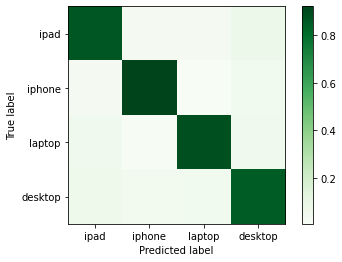

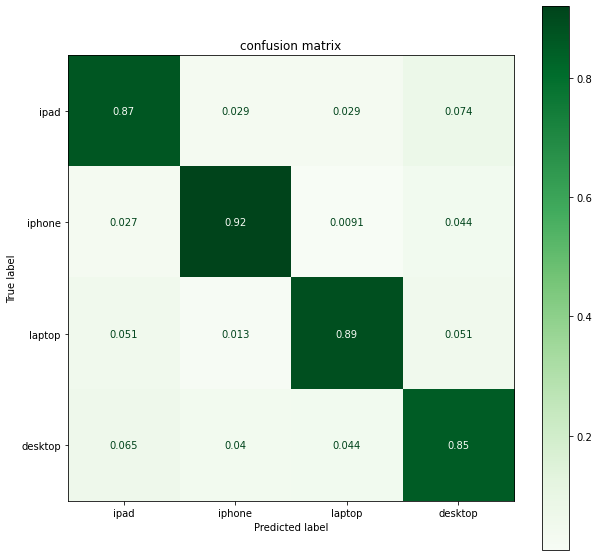

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
inputs = X_test
true = y_test

labels = ["ipad", "iphone", "laptop", "desktop"]
net.eval() #推論モード

with torch.set_grad_enabled(False):   # 推論モードでは勾配を算出しない
    # 処理前の時刻
    t1 = time.time()
    # 出力
    outputs = net(inputs)     # 順伝播
    _, preds = torch.max(outputs, 1)  # ラベルを予測

    correct = 0
    for i in range(len(preds)):
      if preds[i] == true[i]:
        correct += 1

    print(correct / len(preds))
    # 処理後の時刻
    t2 = time.time()
    # 経過時間を表示
    elapsed_time = t2-t1
    print(f"推論時間：{elapsed_time}")

    print(classification_report(preds, true,  digits=4))

    disp = ConfusionMatrixDisplay.from_predictions(preds, true, display_labels = labels,include_values = False ,normalize = "true", cmap = 'Greens')
    fig, ax = plt.subplots(figsize = (10,10))
    plt.title('confusion matrix')
    disp.plot(ax=ax, cmap="Greens")



精度は 0.9912621359223301 %
実行時間は 0.020984172821044922 秒


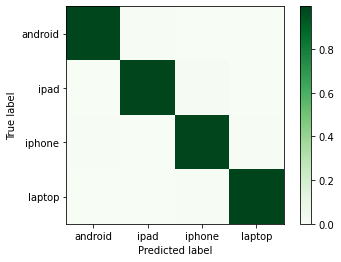

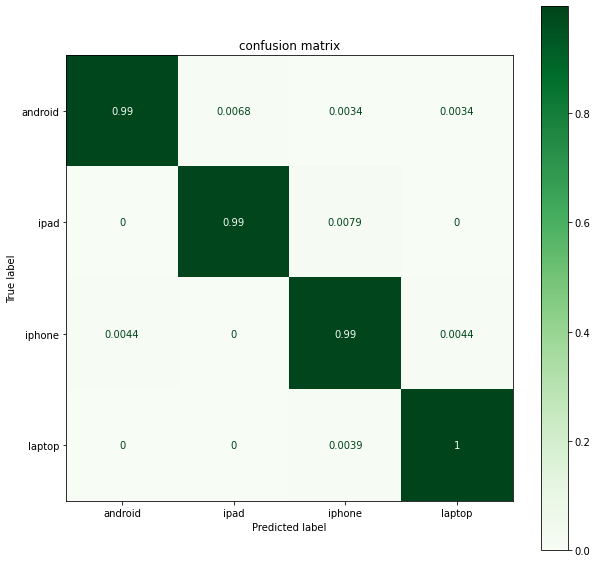

In [ ]:
#ランダムフォレスト
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.ensemble import RandomForestClassifier
import time

X_train = X_train.squeeze()
X_test = X_test.squeeze()

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)



#学習
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

start = time.time() #開始時間記録
score_rf = model_rf.score(X_test, y_test)#結果を推論
end = time.time()  #終了時間記録
print('精度は', score_rf,'%')
print('実行時間は',end-start,'秒')   #処理時間出力

#内訳(緑のやつ)
y_pred = model_rf.predict(X_test)
labels = ["android", "ipad", "iphone", "laptop", "desktop"]
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels = labels,include_values = False ,normalize = "true", cmap = 'Greens')
fig, ax = plt.subplots(figsize = (10,10))
plt.title('confusion matrix')
disp.plot(ax=ax, cmap="Greens")